In [1]:
import pickle
import keras
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from skimage import transform
from sklearn.metrics import accuracy_score
from keras import backend as K

plt.rcParams['image.cmap'] = 'viridis'
plt.rcParams['axes.grid'] = False
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'FreeSerif'
plt.rcParams['lines.linewidth'] = 1.4
plt.rcParams['lines.markersize'] = 8
plt.rcParams['xtick.labelsize'] = 16
plt.rcParams['ytick.labelsize'] = 16
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 16

Using TensorFlow backend.


In [2]:
from IPython.display import HTML, display

# Progress bar drawer
def progress(percent, info):
    return HTML("""
        <progress
            value='{percent}'
            max='100',
            style='width: 50%'
        ></progress>
        <p>{info}</p>
    """.format(percent=100*percent, info=info))

### Данные:
Будем работать с датасетом [FashionMNIST](https://github.com/zalandoresearch/fashion-mnist). 

In [3]:
from keras.datasets import fashion_mnist

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
del y_train, y_test

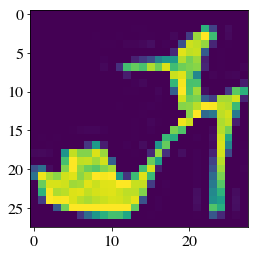

In [4]:
plt.imshow(X_train[9].reshape([28,28]))

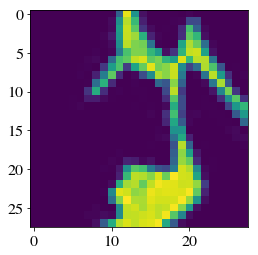

In [5]:
plt.imshow(transform.rotate(X_train[9].reshape([28,28]), 45))

### Задание.
Ваша задача - определить, при каком минимальном угле поворота нейронная сеть фиксированной архитектуры перестает различать обычное и повертнутое изображение. Говоря формально, решаем задачу классификации, исходные изображения принадлежат классу `0`, повернутые - классу `1`. Оцените точность классификации по метрике `accuracy` и ее дисперсию в зависимости от угла поворота изображения и отобразите данную зависимость на графике.

Функция `rotate_dataset` поворачивает поданный датасет на заданный угол. Функция `reset_weights` сбрасывает параметры модели.

*Обращаем ваше внимание, что для качественной оценки данных зависимостей эксперименты для каждого размера выборки стоит повторять многократно на различных случайных подвыборках.*

In [6]:
def rotate_dataset(dataset, angle):
    return np.array(list(map(lambda x: transform.rotate(x, angle), dataset)))

In [7]:
def get_X_and_y(base_dataset, angle):
    rotated_datased = rotate_dataset(base_dataset, angle)
    whole_dataset = np.vstack((base_dataset, rotated_datased)).reshape(-1, 784)
    shuffled_indices = np.arange(len(whole_dataset))
    
    _labels = np.zeros(2*base_dataset.shape[0], dtype=bool)
    _labels[base_dataset.shape[0]:] = True
    _labels = _labels[:, None]
    
    whole_labels = np.array(np.hstack((_labels, ~_labels)), dtype=int)
    
    np.random.shuffle(shuffled_indices)    
    whole_dataset = whole_dataset[shuffled_indices]
    whole_labels = whole_labels[shuffled_indices]
    
    return whole_dataset, whole_labels


In [8]:
# Doesn't work
def reset_layers(model):
    session = K.get_session()
    for layer in model.layers: 
        if isinstance(layer, keras.engine.network.Network):
            reinitLayers(layer)
            continue
        for v in layer.__dict__:
            v_arg = getattr(layer,v)
            if hasattr(v_arg,'initializer'):
                initializer_method = getattr(v_arg, 'initializer')
                initializer_method.run(session=session)
                
def get_model():
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer([784]))
    model.add(keras.layers.Dense(64))
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(2))
    model.add(keras.layers.Activation('softmax'))
    model.compile('adam', 'categorical_crossentropy', 
                         metrics=['accuracy'])
    return model

In [9]:
batch_size = 128
nepochs = 40
nfolds = 3
angle_step = 30
Ns = [500]

nsizes = len(Ns)
angle_range = range(angle_step, 360, angle_step)
nangles = len(angle_range)
# results = nsizes x ntrain_angles x ntest_angles x nfolds  
results = np.empty((nsizes, nangles, nangles, nfolds))

out = display(progress(0, ''), display_id=True)
nsteps = results.size
step = 0
info = """
N = {k}, 
angle_train = {angle_train}/360, 
angle_test = {angle_test}/360, 
fold = {fold}/{nfolds}
"""
model = get_model()
for k_N in range(nsizes):
    for k_angle_train, angle_train in enumerate(angle_range):
        for k_angle_test, angle_test in enumerate(angle_range):
            for fold in range(nfolds):
                step += 1
                out.update(progress(step/nsteps, 
                                    info.format(k=Ns[k_N],
                                                angle_train=angle_train,
                                                angle_test=angle_test,
                                                fold=fold+1,
                                                nfolds=nfolds)))
                
                base_indices = np.random.choice(np.arange(X_train.shape[0]), 
                                                size=Ns[k_N], replace=False)
                base_dataset = X_train[base_indices]
                X, y = get_X_and_y(base_dataset, angle_train)
                
                model.fit(X, y, batch_size=batch_size, epochs=nepochs, 
                          verbose=0)
                
                X_test_whole, y_test_whole = get_X_and_y(X_test, angle_test)
                
                y_test_predicted_whole = model.predict_classes(X_test_whole)
                results[k_N, 
                        k_angle_train, 
                        k_angle_test, 
                        fold] = accuracy_score(y_test_whole[:, 1], 
                                               y_test_predicted_whole)
                reset_layers(model)
    
np.save('results.npy', results)  

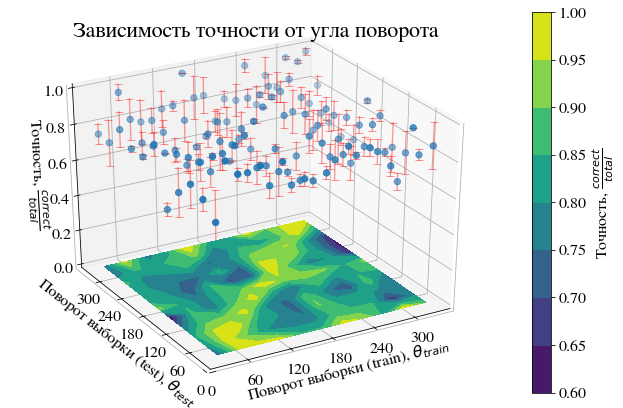

In [143]:
results = np.load('results.npy')  

results_mean = np.mean(results, axis=3)
results_std  = np.std(results, axis=3)

fig = plt.figure(figsize=(11, 7))
ax = fig.add_subplot(111, projection='3d')
ax.set_title('Зависимость точности от угла поворота')
ax.set_xlabel(r'Поворот выборки (train), $\theta_{train}$')
ax.set_ylabel(r'Поворот выборки (test), $\theta_{test}$')
ax.set_zlabel(r'Точность, $\frac{correct}{total}$')
ax.view_init(30, 240)

xs = np.arange(angle_step, 360, angle_step)
X, Y = np.meshgrid(xs, xs)

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for k, N in enumerate(Ns):
    ax.scatter(X, Y, results_mean[k], s=40, label=f'N = {N}', c=colors[k])
    im = ax.contourf(X, Y, results_mean[k], offset=0)
for k, N in enumerate(Ns):
    mean_rav = results_mean[k].ravel()
    std_rav  = results_std[k].ravel()
    X_rav = X.ravel()
    Y_rav = Y.ravel()
    for i in range(X.size):
        ax.plot([X_rav[i], X_rav[i]], 
                [Y_rav[i], Y_rav[i]], 
                [mean_rav[i] - std_rav[i], mean_rav[i] + std_rav[i]], 
                marker='_', lw=1.3, alpha=0.4, c='r')

ax.set_xticks(np.arange(0, 360, angle_step*2))
ax.set_yticks(np.arange(0, 360, angle_step*2))
ax.set_zlim(0, 1)
ax.grid()
# ax.legend()
fig.colorbar(im, orientation='vertical',
             label=r'Точность, $\frac{correct}{total}$')
fig.savefig('ModelFashion.png')
plt.show()

### Вывод

Наибольшая обобщающая способность модели наблюдается, когда угол поворота тестовой выборки превосходит некоторое пороговое значение (~$20^o$). При меньших значениях повёрнутая и не повёрнутая картинки отличаются слишком слабо. Качество ведёт себя периодично с периодом ~$180^o$. Это объясняется тем, что исходная и перевёрнутая версия картинки достаточно похожи. 